# Study the IRFs of Gammapy to understand normalization needed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits

import logging
log = logging.getLogger(__name__)

In [2]:
from gammapy.data import Observation, GTI
from gammapy.data import observatory_locations
from gammapy.datasets import SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.irf import (
    load_cta_irfs,
    EffectiveAreaTable2D,
    Background2D, Background3D,
    EnergyDispersion2D, EDispKernel, EDispKernelMap,
    FoVAlignment
)
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, TimeMapAxis, WcsGeom, RegionNDMap
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
    ExpCutoffPowerLaw3FGLSpectralModel
)
from gammapy.utils.scripts import make_path, make_name

In [3]:
@classmethod
def from_hdulist(cls, hdulist, hdu1="MATRIX", hdu2="EBOUNDS"):
    """Create `EnergyDispersion` object from `~astropy.io.fits.HDUList`.
    Parameters
    ----------
    hdulist : `~astropy.io.fits.HDUList`
        HDU list with ``MATRIX`` and ``EBOUNDS`` extensions.
    hdu1 : str, optional
        HDU containing the energy dispersion matrix, default: MATRIX
    hdu2 : str, optional
        HDU containing the energy axis information, default, EBOUNDS
    """
    matrix_hdu = hdulist[hdu1]
    ebounds_hdu = hdulist[hdu2]

    data = matrix_hdu.data
    header = matrix_hdu.header

    pdf_matrix = np.zeros([len(data), header["DETCHANS"]], dtype=np.float64)

    for i, l in enumerate(data):
        if l.field("N_GRP"):
            m_start = 0
            for k in range(l.field("N_GRP")):

                if np.isscalar(l.field("N_CHAN")):
                    f_chan = l.field("F_CHAN")-1
                    n_chan = l.field("N_CHAN")
                else:
                    f_chan = l.field("F_CHAN")[k]-1
                    n_chan = l.field("N_CHAN")[k]

                pdf_matrix[i, f_chan : f_chan + n_chan] = l.field("MATRIX")[
                    m_start : m_start + n_chan
                ]
                m_start += n_chan

    table = Table.read(ebounds_hdu)
    energy_min = table["E_MIN"].quantity
    energy_max = table["E_MAX"].quantity
    energy_edges = np.append(energy_min.value, energy_max.value[-1]) * energy_min.unit
    energy_axis = MapAxis.from_edges(energy_edges, name="energy", interp="log")

    table = Table.read(matrix_hdu)
    energy_min = table["ENERG_LO"].quantity
    energy_max = table["ENERG_HI"].quantity
    # To avoid that min edge is 0
    energy_min[0] += 1e-2 * (energy_max[0] - energy_min[0])
    energy_edges = np.append(energy_min.value, energy_max.value[-1]) * energy_min.unit
    energy_true_axis = MapAxis.from_edges(
        energy_edges, name="energy_true", interp="log"
    )
    
#     # Normalization
#     x = energy_true_axis.center.value #energy true TeV
#     y = energy_axis.center.value #energy reco
    
#     A = np.trapz(pdf_matrix.T, x=x)
#     A = np.trapz(A, x=y)

#     pdf_matrix=pdf_matrix/A
    
    return cls(axes=[energy_true_axis, energy_axis], data=pdf_matrix)


EDispKernel.from_hdulist = from_hdulist

### CTA IRFs

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


EnergyDispersion2D
------------------

  axes  : ['energy_true', 'migra', 'offset']
  shape : (500, 300, 6)
  ndim  : 3
  unit  : 
  dtype : >f4



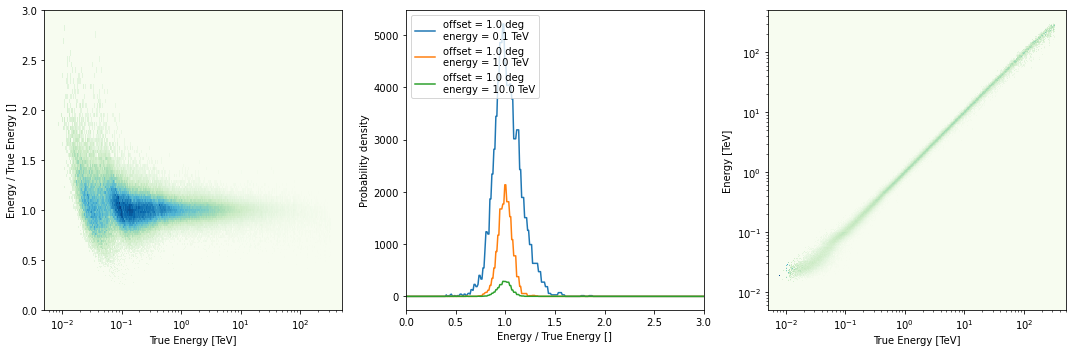

In [45]:
cta_irf = load_cta_irfs("$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits")
cta_edisp = cta_irf['edisp']
print(cta_edisp)
cta_edisp.peek()

In [ ]:
# cta_edisp.normalize()
# print(cta_edisp)
# cta_edisp.peek()

In [ ]:
cta_edisp.axes[1]

In [ ]:
Data = cta_edisp.data
a0 = cta_edisp.axes[0].center.value # energy_true
a1 = cta_edisp.axes[1].center.value # migra
a2 = cta_edisp.axes[2].center.value # offset
print(np.shape(Data), a0.shape, a1.shape, a2.shape)

A = np.trapz(Data, x=a0, axis=0)
B = np.trapz(Data, x=a1, axis=1) # Integrated on migra
C = np.trapz(Data, x=a2, axis=2)

fig, ax = plt.subplots(figsize=(5,5))
y, x = np.meshgrid(a1,a0)
im = ax.imshow(C,
               norm=LogNorm(),
               aspect = 'auto',
               cmap = 'viridis',
               extent = [x.min(), x.max(), y.min(), y.max()],
               origin='lower',
               interpolation='nearest'
              )
fig.colorbar(im, ax = ax)
ax.set_ylabel('Migra')
ax.set_xlabel('True Energy (Tev)')
ax.set_xscale('log')
plt.show()

In [67]:
cta_edisp.axes[2].edges

<Quantity [0., 1., 2., 3., 4., 5., 6.] deg>

In [77]:
cta_edisp_0deg=cta_edisp.to_edisp_kernel(offset=0.5*u.deg,
                                         energy_true=cta_edisp.axes[0]
                                        )
print(cta_edisp_0deg)
cta_edisp_0deg.plot_matrix(add_cbar=True)

TypeError: The value must be a valid Python or Numpy numeric type.

In [75]:
first_array = cta_edisp.data.T[0]
second_array= cta_edisp_0deg.data

np.shape(second_array)

(500, 500)

In [ ]:
data = cta_edisp_0deg.data
x = cta_edisp_0deg.axes[0].center.value #energy true TeV
y = cta_edisp_0deg.axes[1].center.value #energy reco
A = np.trapz(data.T, x=x)
A = np.trapz(A, x=y)
print(A)
cta_edisp_0deg.normalize('energy_true')
data = cta_edisp_0deg.data
x = cta_edisp_0deg.axes[0].center.value #energy true TeV
y = cta_edisp_0deg.axes[1].center.value #energy reco
A = np.trapz(data.T, x=x)
A = np.trapz(A, x=y)
print(A)
cta_edisp_0deg.normalize('energy')
data = cta_edisp_0deg.data
x = cta_edisp_0deg.axes[0].center.value #energy true TeV
y = cta_edisp_0deg.axes[1].center.value #energy reco
A = np.trapz(data.T, x=x)
A = np.trapz(A, x=y)
print(A)

In [ ]:
print('Tag',cta_edisp_0deg.tag)

print(cta_edisp_0deg.required_axes)
print(cta_edisp_0deg.axes[0],cta_edisp_0deg.axes[1])
print('.has_offset_axis:',cta_edisp_0deg.has_offset_axis)

print('.data:',type(cta_edisp_0deg.data),np.shape(cta_edisp_0deg.data))
print('.pdf_matrix:',type(cta_edisp_0deg.pdf_matrix),np.shape(cta_edisp_0deg.pdf_matrix))
print('.quantity:',type(cta_edisp_0deg.quantity),np.shape(cta_edisp_0deg.quantity))
print('unit',cta_edisp_0deg.unit)
print(np.all(cta_edisp_0deg.data==cta_edisp_0deg.pdf_matrix))

print(cta_edisp_0deg.default_interp_kwargs)
print(cta_edisp_0deg.fov_alignment)

print('.is_pointlike:',cta_edisp_0deg.is_pointlike)

In [ ]:
cta_edisp_0deg=cta_edisp.to_edisp_kernel(offset=0.0*u.deg)

cta_edisp_0deg.plot_matrix(add_cbar=True)
plt.show()

cta_edisp_0deg.normalize('energy')
cta_edisp_0deg.plot_matrix(add_cbar=True)
plt.show()

cta_edisp_0deg.normalize('energy_true')
cta_edisp_0deg.plot_matrix(add_cbar=True)
plt.show()

# Build EDispKernel

EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (140, 128)
  ndim  : 2
  unit  : 
  dtype : float64



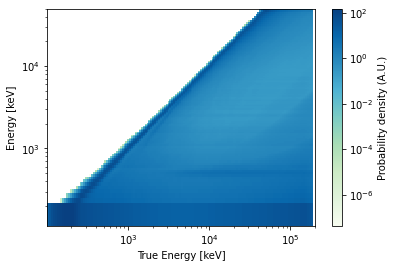

In [4]:
from matplotlib.colors import LogNorm

DRM = '/home/gabriele/Documents/fermiGBM/FermiData/bn120323507/glg_cspec_b0_bn120323507_v01.rsp'
hdulist = fits.open(DRM)
hdu_name_ebounds= hdulist[1].header['EXTNAME']
hdu_name_matrix = hdulist[2].header['EXTNAME']


a=EDispKernel.from_hdulist(hdulist,
                           hdu1 = hdu_name_matrix,
                           hdu2 = hdu_name_ebounds)
print(a)
a.plot_matrix(add_cbar=True,
              norm=LogNorm()
             )
plt.show()

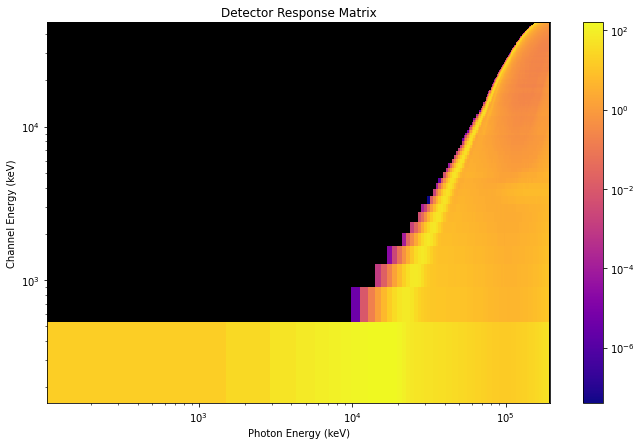

In [25]:
y, x = np.meshgrid(a.axes[1].center.value, a.axes[0].center.value)
z = a.data

z_min, z_max = 4.0E-8, np.abs(z).max()
   
fig, ax = plt.subplots(figsize=(12,7))

c = ax.imshow(z.T,
              cmap ='plasma',
              norm=LogNorm(),
#               vmin = z_min,
#               vmax = z_max,
              extent =[x.min(), x.max(), y.min(), y.max()],
              interpolation ='nearest', 
              origin ='lower')
  
fig.colorbar(c, ax = ax)
ax.set_facecolor('black')
ax.set_title('Detector Response Matrix')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Channel Energy (keV)')
ax.set_xlabel('Photon Energy (keV)')
plt.show()

## Try to get Effective Area

In [28]:
Total_aeff = np.sum(Data)*u.cm**2
print(Total_aeff)

29747.573315516725 cm2


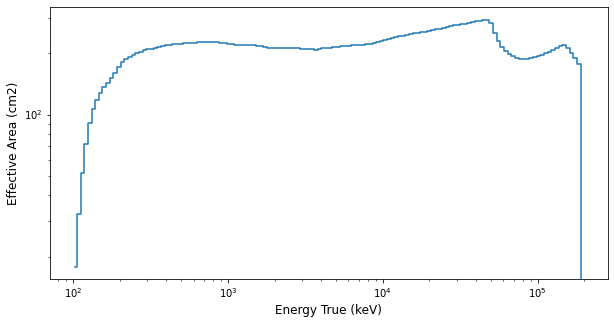

In [35]:
Data = a.data
a0 = a.axes[0].center.value # energy_true
a1 = a.axes[1].center.value # energy reco
#print(np.shape(Data), a0.shape, a1.shape)

#Aeff = np.trapz(Data, x=a1, axis=1) # Integrated on energy reco
Aeff= np.sum(Data, axis=1)

fig, ax=plt.subplots(figsize=(10,5))
ax.step(y=Aeff, x=a.axes[0].center.value, where='mid')
ax.set_xscale('log')
ax.set_xlabel('Energy True (keV)', fontsize='large')
ax.set_yscale('log')
ax.set_ylabel('Effective Area (cm2)',fontsize='large')
plt.show()

In [50]:
Normalization_value = np.trapz(np.trapz(Data,x=a0, axis=0), x=a1)*(u.cm**2 * u.keV * u.keV)
Normalization_value
Matrix_pdf = Data/Total_aeff.value
Matrix_pdf

array([[5.99846859e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08600903e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.74221806e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.22281818e-03, 3.18787492e-04, 2.68163580e-04, ...,
        3.26365678e-05, 3.77310748e-05, 6.57274823e-05],
       [1.05041289e-03, 2.81823779e-04, 2.39200677e-04, ...,
        3.18323885e-05, 3.57753299e-05, 6.13909157e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [64]:
b=EDispKernel(axes=a.axes,data=Matrix_pdf)
print(b)

EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (140, 128)
  ndim  : 2
  unit  : 
  dtype : float64

